# Bayesian Statistics Tutorial

We will be using the pymc3 package to do some Bayesian analyses. You will not be asked to do a lot of coding yourself, but to follow the code already in this tutorial, understand the output, answer some questions about the results and tweak it yourself afterwards.

In [1]:
# Dependencies
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

C:\Users\FI48EY.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running on PyMC3 v3.6


## Generate an AR(1) Process

Let's generate some data, keeping the data generator parameters the same as in the AR(1) exercise from earlier on today. We can do a simple plot afterwards just to see what it looks like.

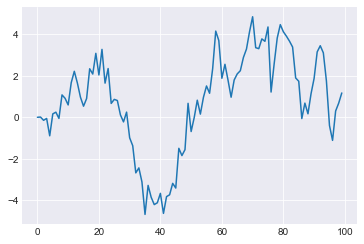

In [2]:
np.random.seed(seed=1848)

T = 100
y = np.zeros((T,))
rho = 0.95

for i in range(1,T):
    y[i] = rho * y[i-1] + np.random.normal()

plt.plot(y);

## Run Bayesian AR(1) Model

To run any Bayesian model, we need to have our ingredients:
- **The model**: in this case an AR(1) model
- **The data**: already generated
- **The priors**: defined below

In addition to these, we will also need to specify some computation-specific parameters:
- **Number of chains**: How many Markov chains do we want to compute? Below, this is set to 2
- **Sample per chain**: How many samples should be taken from each Markov chain? Below, this is set to 2000
- **Tune**: How much of the initial marginal posterior distribution should be sampled as an initial burn-in? This is set to 2000
- **Sampling Method**: Default for pymc3 is NUTS (No U Turn Sampling). Below we use Metropolis-Hastings

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████████| 8000/8000 [00:05<00:00, 1387.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


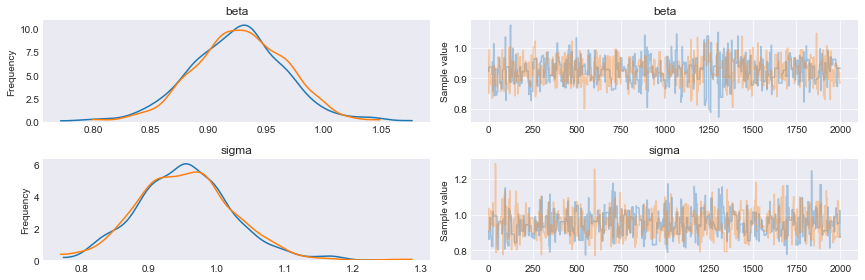

In [3]:
# Number of chains
chains = 2
# Number of posterior samples to get from the posterior distribution, per parameter
sample = 2000

# Run the model
with pm.Model() as ar1:
    # "beta" is our estimated rho
    beta = pm.Normal('beta', mu = 0, sd = 1e2)
    # The prior for the noise in the data
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    # We specify the data as following an AR(1) model
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    # Run the Markov chains
    trace = pm.sample(sample, cores = chains, tune = 2000, step = pm.Metropolis())

pm.traceplot(trace);

We can get detailed histograms of the parameters' marginal posterior densities

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F0EAC50>,
      dtype=object)

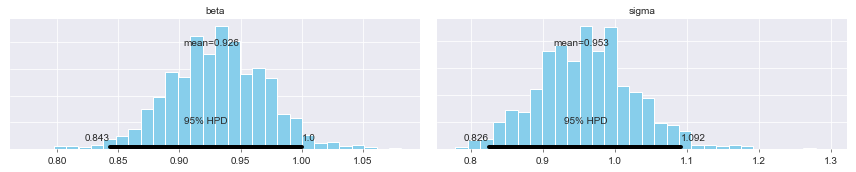

In [4]:
pm.plot_posterior(trace)

Look at how the posterior density compares to the prior

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000DED7BE0>,
      dtype=object)

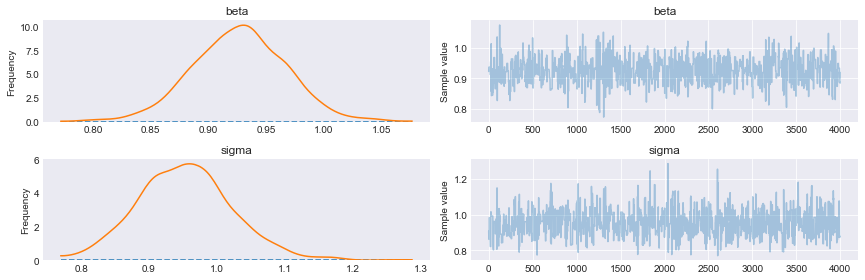

In [5]:
pm.traceplot(trace, combined = True, priors = [pm.Normal.dist(mu = 0, sd = 1e2), pm.Gamma.dist(alpha = 1e-3, beta = 1e-3)])

Some questions about the last outputs:
1. Are there any obvious biases in the estimated rho (i.e. beta) values? Remember that rho = 0.95
2. How does it differ from the plot of the AR(1) rho estimates we did before in the day?
3. If there is a difference, where is this coming from?

One potential issue with Markov chains are that the draws can be correlated to each other. Let's do an autocorrelation plot of the estimated parameters to see if this is an issue. 

Are there any obvious autocorrelation issues?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D455048>,
      dtype=object)

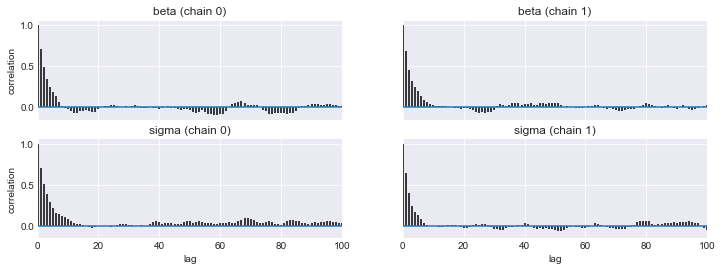

In [6]:
pm.autocorrplot(trace)

There are indeed some auto-correlation issues within the chain. We can thin the chains 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000F3AA748>,
      dtype=object)

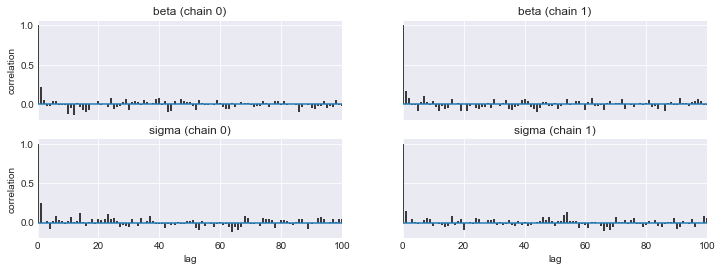

In [7]:
pm.autocorrplot(trace[::5])

Now let's tweak our model to try and improve some of the issues we had:

- Bias in the Bayesian estimator of beta
  - According to [this](https://arxiv.org/ftp/arxiv/papers/1611/1611.08747.pdf) paper, giving the estimator a truncated normal distribution as a prior reduces the bias
- Autocorrelation
  - The No U Turn Sampler (NUTS) in pymc3 theoretically avoids autocorrelation issues. How it does this is, admittedly, a bit complicated. You can find a discussion, with some links, [here](https://stats.stackexchange.com/questions/311813/can-somebody-explain-to-me-nuts-in-english)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|███████████████| 8000/8000 [00:15<00:00, 530.13draws/s]
The acceptance probability does not match the target. It is 0.8923805875661059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9088014464936034, but should be close to 0.8. Try to increase the number of tuning steps.


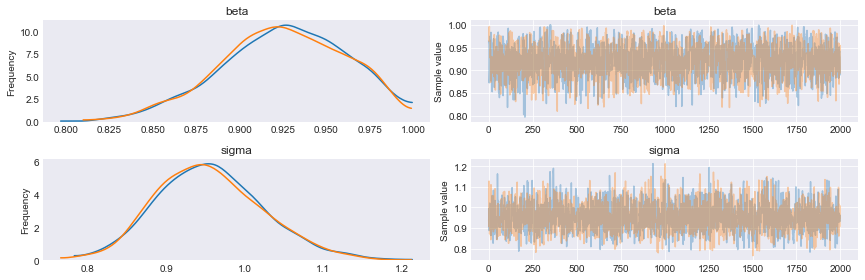

In [8]:
with pm.Model() as ar1:
    # truncate the prior of beta between -1 and 1
    BoundedNormal = pm.Bound(pm.Normal, upper = 1.0, lower = -1.0)
    beta = BoundedNormal('beta', mu = 0, sd = 1e2)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    trace = pm.sample(sample, cores = chains, tune = 2000)

pm.traceplot(trace);

Have we solved some of the issues? The chains seem more converged than before, but there is still a bias. Let's see if we still have an autocorrelation issue

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D519A90>,
      dtype=object)

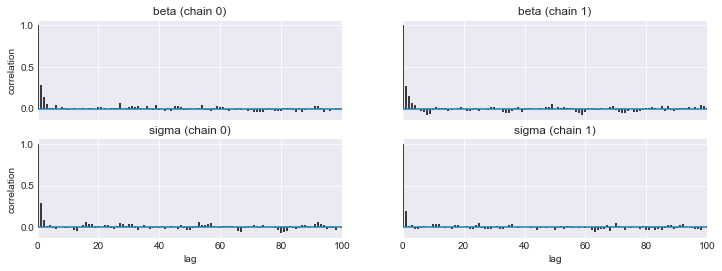

In [9]:
pm.autocorrplot(trace)

At least we have no more autocorrelation in the posterior draws! 

Below, we can see a summary table of the marginal posterior draws.

What do the following columns indicate? Write as if you are explaining it to your business counter part in a project/manager/grandmother/neighbor. Don't worry, technical explanations are provided in the URLs in the parentheses!
- mean (tip: https://docs.pymc.io/api/stats.html)
- sd (tip: https://docs.pymc.io/api/stats.html)
- mc_error (tip: https://docs.pymc.io/api/stats.html)
- hpd_2.5 (tip: https://docs.pymc.io/api/stats.html)
- hpd_97.5 (tip: https://docs.pymc.io/api/stats.html)
- n_eff (tip: thttps://docs.pymc.io/api/diagnostics.html)
- Rhat (tip: https://docs.pymc.io/api/diagnostics.html)

Bonus Questions: 
- Based on your estimation, would you conclude that the data has a unit root (beta = 1)? Motivate your answer!
- Based on this summary, would you change anything about this particular run of the AR(1) model? If so, why? If not, why not?

In [10]:
# Summarize the results
pm.summary(trace).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9246,0.0358,0.0008,0.8564,0.9905,1973.8394,1.0000
sigma,0.9550,0.0675,0.0013,0.8357,1.0989,2476.1444,1.0001


Now let's play around with the prior of beta
1. Change prior of beta to a uniform distribution (-5, 5) and re-run everything. Did this change anything?
2. Make the prior much more informative in the correct range (-1, 1) and then the incorrect range (2, 3). What happens?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|███████████████| 8000/8000 [00:15<00:00, 507.51draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9245,0.0369,0.0009,0.8582,0.9966,1904.6976,0.9998
sigma,0.9551,0.0699,0.0018,0.8198,1.0915,1511.8269,1.0035


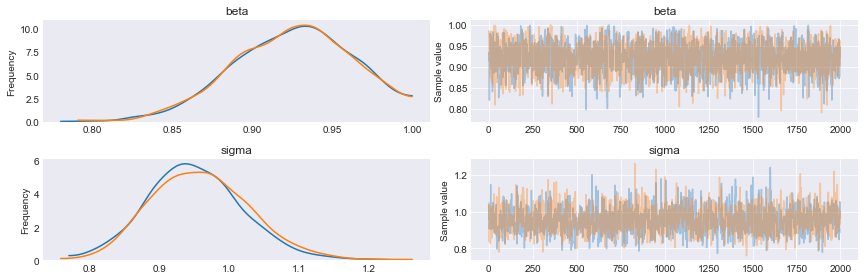

In [11]:
chains = 2
sample = 2000

with pm.Model() as ar1:
    beta = pm.Uniform('beta', lower = -1, upper = 1)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3) 
    data = pm.AR('y', beta, sd = sd_prior, observed = y)
    trace = pm.sample(sample, cores = chains, tune = 2000)

pm.traceplot(trace);
pm.summary(trace).round(4)

# Using Real Data

Now it's time for you to try out what you learned above by yourself with real data! Below you can find the code to load ING's daily stock price data (closing). It is sub-setted to between the 1st of February 2018 - 1st of February 2019. This period marks the first year of Mehmet's (one of the workshop presenters) employment at ING. He is happy about it. However, it seems ING's stock price is not so happy about it.



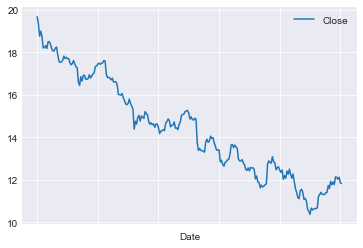

In [12]:
# Get ING stock prices data (Yahoo Finance)
data = pd.read_csv('ING.csv')
# Make closing daily price the variable of interest
data = data[['Date','Close']]
# Set Date as index
data = data.set_index('Date')
# Subset to Feb 2018 - Feb 2019
data = data.loc['2018-02-01':'2019-02-01']
data.plot()

### Question 1

The prior for the beta value is chosen to be the truncated normal distribution (between -1 and 1), as a recent paper claims that this reduces the bias in the estimator. I also opt for the NUTS sampler, in order to avoid auto-correlation issues within the chains.

The plots of the chains indicate that convergence may have been achieved. The Rhat figure is close to 1. However increasing the burn-in sample might make sense. Also note that the n_eff for sigma is larger than the number of draws we have per chain. This can happen when the values in the chains are anti-correlated (i.e. have a negative correlation to each other). More information can be found in [this discussion](https://statmodeling.stat.columbia.edu/2018/01/18/measuring-speed-stan-incorrectly-faster-thought-cases-due-antithetical-sampling/).

The chains don't seem to be auto-correlated, which is good!


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|███████████████| 8000/8000 [00:17<00:00, 455.90draws/s]


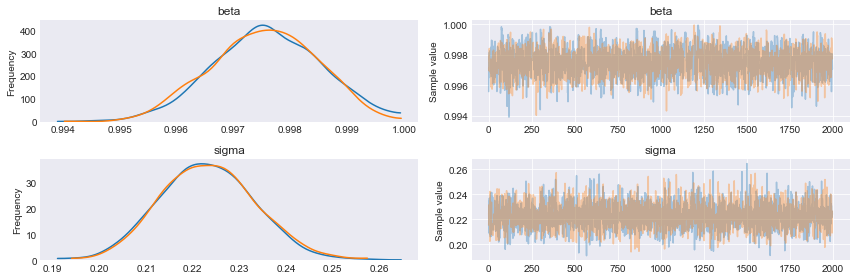

In [16]:
# Run this data through an AR(1) model
# Number of chains
chains = 2
# Number of posterior samples to get from the posterior distribution, per parameter
sample = 2000

# Run the model!
with pm.Model() as ar1:
    BoundedNormal = pm.Bound(pm.Normal, upper = 1.0, lower = -1.0)
    # "beta" is our estimated rho, here we specify the prior as following a truncated normal distribution
    beta = BoundedNormal('beta', mu = 0, sd = 1e2)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3)  
    estimate = pm.AR('estimate', beta, sd = sd_prior, observed = data['Close'])
    # 
    trace = pm.sample(sample, cores = chains, tune = 2000)

pm.traceplot(trace);

In [17]:
pm.summary(trace).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9976,0.0009,0.0000,0.9956,0.9992,2032.1619,1.0006
sigma,0.2232,0.0102,0.0002,0.2030,0.2421,3668.2486,1.0003


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000104CEEB8>,
      dtype=object)

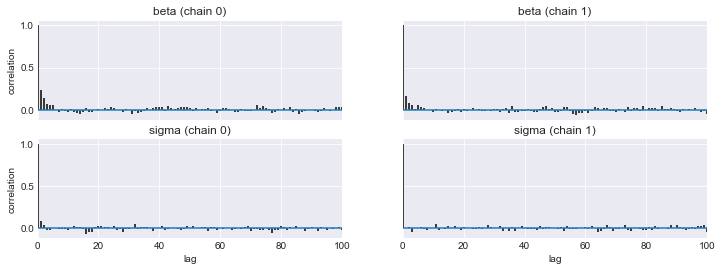

In [18]:
pm.autocorrplot(trace)

### Question 2

Just for fun, let's change the prior of beta to uniform distribution between -1 and 1 (feel free to be more creative). The distribution of sigma will be kept the same. The sampler will be kept the same (NUTS), but the size of the burn-in draws are increased from 2000 to 3000. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]
Sampling 2 chains: 100%|█████████████| 10000/10000 [00:17<00:00, 580.52draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6039421431849197, but should be close to 0.8. Try to increase the number of tuning steps.


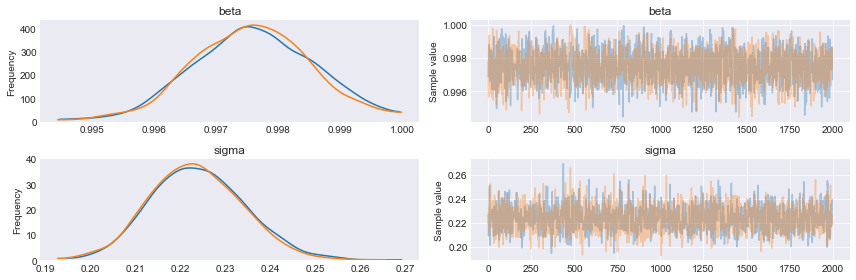

In [19]:
# Run this data through an AR(1) model
# Number of chains
chains = 2
# Number of posterior samples to get from the posterior distribution, per parameter
sample = 2000

# Run the model!
with pm.Model() as ar1: 
    beta = pm.Uniform('beta', lower = -1, upper = 1)
    sd_prior = pm.Gamma('sigma', alpha = 1e-3, beta = 1e-3)  
    # We specify the data as following an AR(4) model
    estimate = pm.AR('estimate', beta, sd = sd_prior, observed = data['Close'])
    # 
    trace = pm.sample(sample, cores = chains, tune = 3000)

pm.traceplot(trace);

In [20]:
pm.summary(trace).round(4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.9976,0.0010,0.0000,0.9958,0.9996,1399.4091,1.0001
sigma,0.2236,0.0103,0.0003,0.2051,0.2449,1447.0607,1.0011


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000011724940>,
      dtype=object)

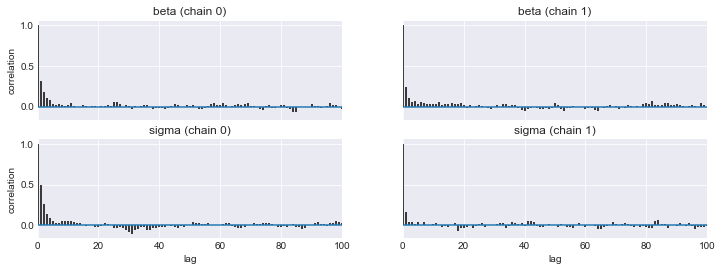

In [21]:
pm.autocorrplot(trace)

### Question 3

We run the three tests outlined in the ARIMA exercise. And we find that the ADF and KPSS tests claim that the series is not stationary. This is in line with the result we found for beta - it is very close to 1. One of the tests though, the PP, claims that no differencing is required. 

Based on the other two tests results and what we have seen from the posterior distribution of beta, the case that the series is not stationary is quite strong.

In [22]:
from pmdarima import arima
# Let's see if this series requires the first order difference to be taken
# We can conduct a Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
KPSS_test = arima.stationarity.KPSSTest(alpha = 0.05)
print(
    f"Results of the KPSS test:\n"
    f"pval:\t{KPSS_test.is_stationary(data['Close'])[0]}\n"
    f"sig:\t{KPSS_test.is_stationary(data['Close'])[1]}\n"
)
# True means we CAN REJECT the null hypothesis that the time-series IS stationary, so we need to do differencing
# False means we CAN'T REJECT the null hypothesis that the time-series IS stationary, so we don't have to do differencing

# We can also use a test which can indicate how many times we need to difference our data to make it stationary
available_tests = ['adf', 'kpss', 'pp']
print("Required differencing according to tests:")
for t in available_tests:
    print(f"{t}:\t{arima.utils.ndiffs(data['Close'], test = t)} differencing is required")

Results of the KPSS test:
pval:	0.01
sig:	True

Required differencing according to tests:
adf:	1 differencing is required
kpss:	1 differencing is required
pp:	0 differencing is required


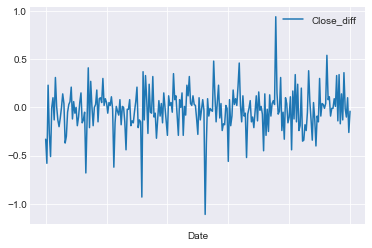

In [23]:
# Take the first difference of the stock prices
data_lagged = data.rename(columns={'Close': 'Close_lagged'}).shift(1)
data_lagged = pd.concat([data, data_lagged], axis = 1)
data_diff = data_lagged.assign(Close_diff = data_lagged['Close'] - data_lagged['Close_lagged'])
data_diff = data_diff[['Close_diff']][1:]
data_diff.plot()

### Question 4

The time series is not stationary and taking the first difference shows that there is most likely a unit root. So the AR(1) is not the best model to use without taking any difference first. 